<a href="https://colab.research.google.com/github/Ygorca125/Projeto-Prev_Ibov/blob/main/Projeto_Previs%C3%A3o_IBOV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from prophet import Prophet
df = pd.read_csv("/content/Dados Históricos - Ibovespa.csv")
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,03.12.2025,161.772,161.094,161.790,161.093,"91,32K","0,42%"
1,02.12.2025,161.092,158.612,161.092,158.612,"8,43B","1,56%"
2,01.12.2025,158.611,159.073,159.224,158.029,"7,50B","-0,29%"
3,28.11.2025,159.072,158.358,159.689,158.078,"8,02B","0,45%"
4,27.11.2025,158.360,158.554,158.864,158.167,"4,47B","-0,12%"


In [ ]:
df.tail()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
497,08.12.2023,127.094,126.010,127.289,125.562,"10,75M","0,86%"
498,07.12.2023,126.010,125.623,126.581,125.566,"10,51M","0,31%"
499,06.12.2023,125.623,126.907,127.538,125.614,"10,84M","-1,01%"
500,05.12.2023,126.903,126.802,127.489,126.491,"11,96M","0,08%"
501,04.12.2023,126.803,128.183,128.183,126.643,"10,27M","-1,08%"


In [ ]:
#Verificar o Dtype de cada coluna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      502 non-null    object 
 1   Último    502 non-null    float64
 2   Abertura  502 non-null    float64
 3   Máxima    502 non-null    float64
 4   Mínima    502 non-null    float64
 5   Vol.      502 non-null    object 
 6   Var%      502 non-null    object 
dtypes: float64(4), object(3)
memory usage: 27.6+ KB


In [ ]:
#Verificando se temos dados nulos
df.isnull().sum()

,0
Data,0
Último,0
Abertura,0
Máxima,0
Mínima,0
Vol.,0
Var%,0


In [ ]:
#Transformar data em formato datetime
df["Data"] = pd.to_datetime(df["Data"], format="%d.%m.%Y")
df = df.sort_values(by="Data", ascending=True).reset_index(drop=True)


In [ ]:
#Transformando no padrão do Prophet
df_prophet = pd.DataFrame()
df_prophet["ds"] = pd.to_datetime(df["Data"], format="%d.%m.%Y")
df_prophet["y"]  = df["Último"].astype(float)


In [ ]:
#Verificando se os últimos dados são os mais recentes, para a previsão ficar correta, já que utiliza os últimos dados
df_prophet.tail()

,ds,y
497,2025-11-27,158.360
498,2025-11-28,159.072
499,2025-12-01,158.611
500,2025-12-02,161.092
501,2025-12-03,161.772


In [ ]:
def trend_accuracy_lastN(df, params, last_n=30, k=3): #Pegaremos os últimos 3 dias para ter um momentum mais próximo do real, já que o IBOV tem muito ruído
    df = df.sort_values("ds").reset_index(drop=True)

    if len(df) <= last_n + k:
        return np.nan

    train = df.iloc[:-last_n].copy()
    test  = df.iloc[-last_n:].copy()

    m = Prophet(**params)
    m.fit(train)

    fcst = m.predict(test[["ds"]])[["ds", "yhat"]]
    merged = test.merge(fcst, on="ds", how="left")

    # referência = média móvel dos últimos k dias
    prev_actual = np.r_[
        train["y"].iloc[-k:].mean(),
        merged["y"].rolling(k).mean().shift(1).values[1:]
    ]

    real_up = merged["y"].values > prev_actual
    pred_up = merged["yhat"].values > prev_actual

    return float((real_up == pred_up).mean())


In [ ]:

def prophet_gridsearch_lastN(df_prophet: pd.DataFrame, last_n: int = 30):

    param_grid = {
        "yearly_seasonality": [True],
        "weekly_seasonality": [False, True],
        "daily_seasonality": [False],
        "seasonality_mode": ["additive", "multiplicative"],
        "changepoint_prior_scale": [0.01, 0.05, 0.1, 0.3],
        "seasonality_prior_scale": [1.0, 5.0, 10.0],
        "n_changepoints": [10, 25, 50],
    }

    keys = list(param_grid.keys())
    combos = list(product(*[param_grid[k] for k in keys]))

    results = []
    total = len(combos)

    for i, values in enumerate(combos, start=1):
        params = dict(zip(keys, values))

        try:
            acc = trend_accuracy_lastN(df_prophet, params=params, last_n=last_n)
        except Exception:
            acc = np.nan

        results.append({**params, f"acc_last{last_n}": acc})
        print(f"[{i}/{total}] acc_last{last_n}={acc:.4f} | params={params}")

    res_df = pd.DataFrame(results).sort_values(f"acc_last{last_n}", ascending=False).reset_index(drop=True)
    best_params = res_df.iloc[0][keys].to_dict()

    print("\n==================== RESULTADO FINAL ====================")
    print(f"Melhores parâmetros (por acurácia de tendência nos últimos {last_n} dias):")
    print(best_params)
    print(f"Melhor acc_last{last_n}: {res_df.iloc[0][f'acc_last{last_n}']:.4f}")
    print("========================================================\n")

    return best_params, res_df

In [ ]:
import numpy as np
from itertools import product


baseline_params = dict(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="additive",
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=10.0,
    n_changepoints=25
)

baseline_acc = trend_accuracy_lastN(
    df_prophet,
    params=baseline_params,
    last_n=30
)

if np.isnan(baseline_acc):
    print("Baseline acc retornou NaN")
else:
    print(f" Baseline acc (últimos 30 dias): {baseline_acc:.4f}")


best_params, resultados = prophet_gridsearch_lastN(
    df_prophet,
    last_n=30
)

print("Top 10 combinações:")
print(resultados.head(10))


 Baseline acc (últimos 30 dias): 0.3333
[1/144] acc_last30=0.2667 | params={'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'n_changepoints': 10}
[2/144] acc_last30=0.2667 | params={'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'n_changepoints': 25}
[3/144] acc_last30=0.2667 | params={'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'n_changepoints': 50}
[4/144] acc_last30=0.2667 | params={'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'n_changepoints': 10}


In [ ]:
best_params = dict(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.3,
    seasonality_prior_scale=10.0,
    n_changepoints=10
)

In [ ]:
from prophet import Prophet
import numpy as np
import pandas as pd
from IPython.display import display

best_params = dict(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.5, #ajuste o changepoint devido ao nível alto de ruído do ibov
    seasonality_prior_scale=10.0,
    n_changepoints=10
)


df_prophet = df_prophet.sort_values("ds").reset_index(drop=True)

model = Prophet(**best_params)
model.fit(df_prophet)


# PREVISÃO D+1
future = model.make_future_dataframe(periods=1)
forecast = model.predict(future)

previsao_d1 = forecast.iloc[-1][["ds", "yhat", "yhat_lower", "yhat_upper"]]

print("📈 Previsão para o próximo dia:")
print(previsao_d1)

ultimo_real = df_prophet["y"].iloc[-1]
tendencia_prevista = "ALTA" if previsao_d1["yhat"] > ultimo_real else "QUEDA"

print(f"Tendência prevista para D+1: {tendencia_prevista}")


# ACURÁCIA DIRECIONAL (30 dias)
acc_30 = trend_accuracy_lastN(
    df_prophet,
    params=best_params,
    last_n=30
)

print(f"✅ Acurácia direcional (últimos 30 dias): {acc_30:.2%}")


# TABELA DE BACKTEST (ÚLTIMOS 30 DIAS)
last_n = 30

# treino e teste
train = df_prophet.iloc[:-last_n].copy()
test  = df_prophet.iloc[-last_n:].copy()

# previsão para o período de teste
fcst_test = model.predict(test[["ds"]])[["ds", "yhat"]]

# merge real x previsto
backtest_df = test.merge(fcst_test, on="ds", how="left")

# média móvel (momentum)
k = 3
prev_actual = np.r_[
    train["y"].iloc[-k:].mean(),
    backtest_df["y"].rolling(k).mean().shift(1).values[1:]
]

backtest_df["tend_real"] = (backtest_df["y"].values > prev_actual).astype(int)
backtest_df["tend_prev"] = (backtest_df["yhat"].values > prev_actual).astype(int)

backtest_df["acerto"] = backtest_df["tend_real"] == backtest_df["tend_prev"]

cols = ["ds", "y", "yhat", "tend_real", "tend_prev", "acerto"]

df_view = backtest_df[cols].copy()
df_view["acerto"] = df_view["acerto"].map({True: "✅", False: "❌"})

display(df_view)


📈 Previsão para o próximo dia:
ds            2025-12-04 00:00:00
yhat                   160.164073
yhat_lower             158.023942
yhat_upper             162.278941
Name: 502, dtype: object
Tendência prevista para D+1: QUEDA
✅ Acurácia direcional (últimos 30 dias): 80.00%


,ds,y,yhat,tend_real,tend_prev,acerto
0,2025-10-22,144.873,146.166055,1,1,✅
1,2025-10-23,145.721,146.434076,0,0,✅
2,2025-10-24,146.172,146.790899,0,0,✅
3,2025-10-27,146.969,148.230292,1,1,✅
4,2025-10-28,147.429,149.017253,1,1,✅
5,2025-10-29,148.633,149.527454,1,1,✅
6,2025-10-30,148.780,149.858284,1,1,✅
7,2025-10-31,149.540,150.248848,1,1,✅
8,2025-11-03,150.454,151.623033,1,1,✅
9,2025-11-04,150.704,152.337718,1,1,✅


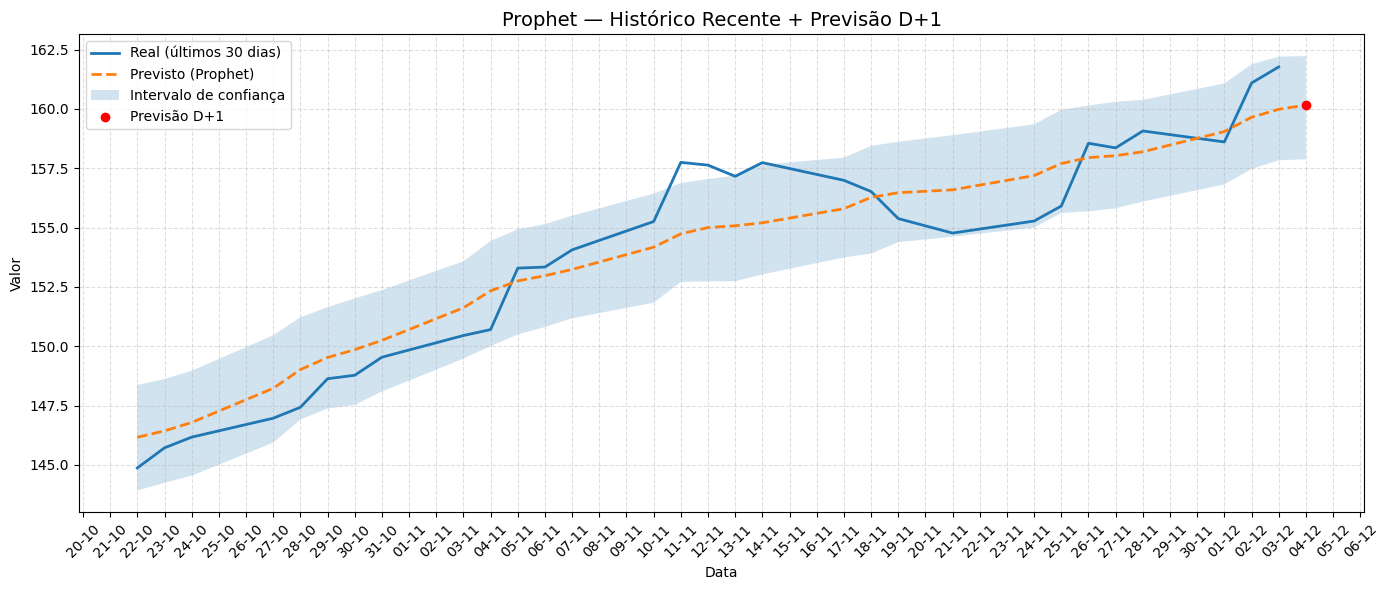

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from prophet import Prophet

last_n = 30


dfp = df_prophet.sort_values("ds").reset_index(drop=True)


m_plot = Prophet(**best_params)
m_plot.fit(dfp)

future = m_plot.make_future_dataframe(periods=1)
forecast = m_plot.predict(future)[["ds", "yhat", "yhat_lower", "yhat_upper"]]

# merge real + previsto
plot_df = forecast.merge(dfp[["ds", "y"]], on="ds", how="left")

plot_30 = plot_df.tail(last_n + 1)  # +1 para incluir D+1

plt.figure(figsize=(14, 6))


plt.plot(
    plot_30["ds"][:-1],
    plot_30["y"][:-1],
    label="Real (últimos 30 dias)",
    linewidth=2
)


plt.plot(
    plot_30["ds"],
    plot_30["yhat"],
    label="Previsto (Prophet)",
    linestyle="--",
    linewidth=2
)

# Intervalo de confiança
plt.fill_between(
    plot_30["ds"],
    plot_30["yhat_lower"],
    plot_30["yhat_upper"],
    alpha=0.2,
    label="Intervalo de confiança"
)

# Destaque do ponto D+1
plt.scatter(
    plot_30["ds"].iloc[-1],
    plot_30["yhat"].iloc[-1],
    color="red",
    zorder=5,
    label="Previsão D+1"
)


ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m"))
plt.xticks(rotation=45)


plt.title("Prophet — Histórico Recente + Previsão D+1", fontsize=14)
plt.xlabel("Data")
plt.ylabel("Valor")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd


df_eval = plot_30.dropna(subset=["y", "yhat"]).copy()

y_true = pd.to_numeric(df_eval["y"], errors="coerce")
y_pred = pd.to_numeric(df_eval["yhat"], errors="coerce")


mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))


nonzero = y_true != 0
mape = (
    np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])) * 100
    if nonzero.any()
    else np.nan
)

print("📌 Métricas (últimos 30 dias, sem D+1):")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAPE = {mape:.2f}%")


📌 Métricas (últimos 30 dias, sem D+1):
MAE  = 1.2523
RMSE = 1.4351
MAPE = 0.81%


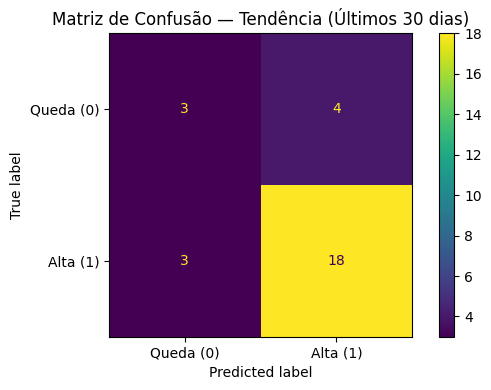

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# PARÂMETRO DE MOMENTUM (IGUAL AO MODELO)
k = 3

# garantir ordenação
plot_30 = plot_30.sort_values("ds").reset_index(drop=True)


prev_actual = np.r_[
    plot_30["y"].iloc[:k].mean(),                      # para o 1º ponto válido
    plot_30["y"].rolling(k).mean().shift(1).values[1:]
]

plot_30["prev_ref"] = prev_actual

# remove linhas inválidas
tmp = plot_30.dropna(subset=["y", "yhat", "prev_ref"]).copy()


# TENDÊNCIA REAL E PREVISTA (0=queda, 1=alta)
tmp["tend_real"] = (tmp["y"] > tmp["prev_ref"]).astype(int)
tmp["tend_prev"] = (tmp["yhat"] > tmp["prev_ref"]).astype(int)

y_true = tmp["tend_real"]
y_pred = tmp["tend_prev"]


cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Queda (0)", "Alta (1)"]
)

fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(values_format="d", ax=ax)
ax.set_title("Matriz de Confusão — Tendência (Últimos 30 dias)")
plt.tight_layout()
plt.show()


# Back Testing

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet

# 1) Garantir df limpo e ordenado
dfp = df_prophet.copy()
dfp["ds"] = pd.to_datetime(dfp["ds"], errors="coerce")
dfp["y"]  = pd.to_numeric(dfp["y"], errors="coerce")

dfp = (dfp.dropna(subset=["ds", "y"])
          .sort_values("ds")
          .drop_duplicates(subset=["ds"], keep="last")
          .reset_index(drop=True))


# 2) Rolling backtest (1 passo à frente)
rolling_preds = []
rolling_dates = []
rolling_real  = []

window = 180  # tamanho mínimo de treino antes de começar a prever

for i in range(window, len(dfp)):   # prevê o ponto i (não i+1)
    train_df = dfp.iloc[:i].copy()
    next_date = dfp.loc[i, "ds"]
    real_next_value = float(dfp.loc[i, "y"])


    m = Prophet(**best_params) if "best_params" in globals() else Prophet()
    m.fit(train_df)

    # prevê EXATAMENTE a data do próximo ponto real
    future_next = pd.DataFrame({"ds": [next_date]})
    forecast_next = m.predict(future_next)

    pred_next = float(forecast_next["yhat"].iloc[0])

    rolling_preds.append(pred_next)
    rolling_real.append(real_next_value)
    rolling_dates.append(next_date)


# 3) DataFrame final
backtest_df = pd.DataFrame({
    "Data": rolling_dates,
    "Real": rolling_real,
    "Previsto": rolling_preds
}).sort_values("Data").reset_index(drop=True)



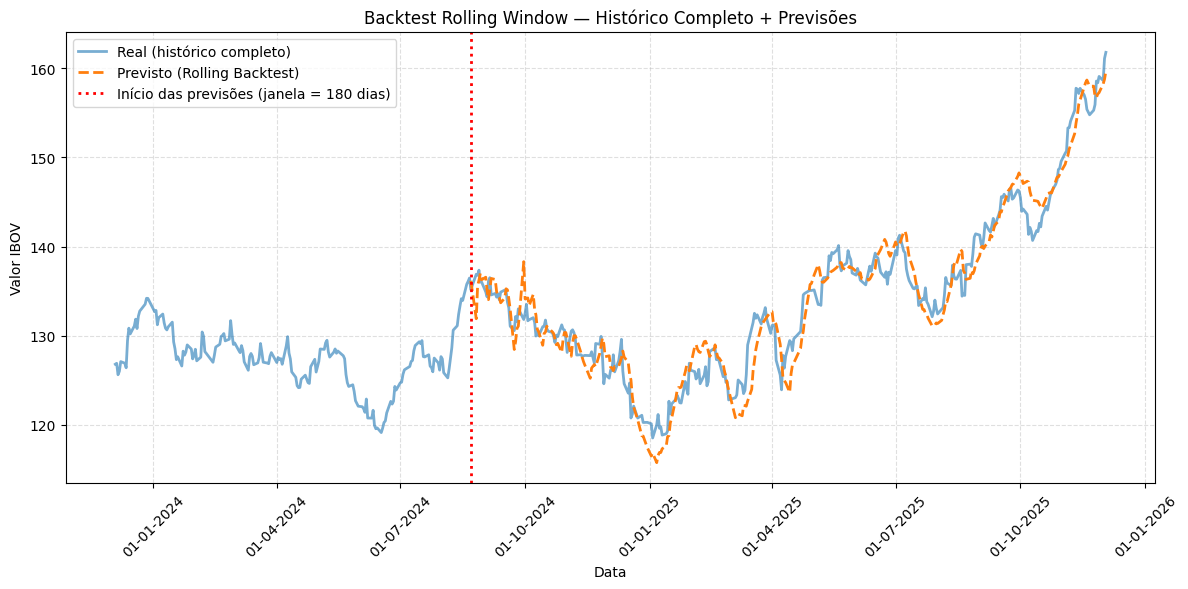

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df_real = dfp.copy()
df_real["ds"] = pd.to_datetime(df_real["ds"], errors="coerce")
df_real["y"] = pd.to_numeric(df_real["y"], errors="coerce")

df_real = df_real.dropna(subset=["ds", "y"]).sort_values("ds")

bt = backtest_df.copy()
bt["Data"] = pd.to_datetime(bt["Data"], errors="coerce")
bt["Real"] = pd.to_numeric(bt["Real"], errors="coerce")
bt["Previsto"] = pd.to_numeric(bt["Previsto"], errors="coerce")

bt = bt.dropna(subset=["Data", "Real", "Previsto"]).sort_values("Data")

inicio_backtest = bt["Data"].iloc[0]


plt.figure(figsize=(12, 6))

# Série real completa
plt.plot(
    df_real["ds"],
    df_real["y"],
    label="Real (histórico completo)",
    linewidth=2,
    alpha=0.6
)

# Série prevista (apenas após janela de 180 dias)
plt.plot(
    bt["Data"],
    bt["Previsto"],
    label="Previsto (Rolling Backtest)",
    linestyle="--",
    linewidth=2
)

# Linha vertical indicando início do backtest
plt.axvline(
    inicio_backtest,
    color="red",
    linestyle=":",
    linewidth=2,
    label="Início das previsões (janela = 180 dias)"
)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y"))
plt.xticks(rotation=45)

plt.title("Backtest Rolling Window — Histórico Completo + Previsões")
plt.xlabel("Data")
plt.ylabel("Valor IBOV")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()
